In [1]:
import bz2
import pickle
import _pickle as cPickle
import numpy as np
from PIL import Image
from nats_bench.api_utils import pickle_load
import re
import os
import matplotlib.pyplot as plt
import json
import networkx as nx


# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='bytes')
    return dict


def get_index_from_name(name):
    pattern = r'@(\d+)'
    m = re.search(pattern, name)
    if m:
        return int(m.group(1))
    else:
        print('Not possible to extract number from', name)
        return None


def get_validation_and_test_acc(current_data, validation_results_arr, test_results_arr):
    for key in current_data:
        if 'valid' in key:
            idx = get_index_from_name(key)
            validation_results_arr[idx] = current_data[key]
        elif 'ori-test' in key:
            idx = get_index_from_name(key)
            test_results_arr[idx] = current_data[key]
        else:
            print(f'Following key was missing:', key)


def get_train_acc(current_data, train_result_arr):
    for key in current_data:
        ind = int(key)
        train_result_arr[ind] = current_data[key]


def get_max_value_and_index(np_arr):
    max_val_value = np.amax(np_arr, axis=None, out=None)
    max_val_idx = np.where(np_arr == max_val_value)[0]
    return max_val_value, max_val_idx


def get_dict_for_one_architecture(data):
    data_dict = {}
    for number_epochs_str in data:
        for dataset_name_and_seed in data[number_epochs_str]['all_results']:
            dataset_name, seed = dataset_name_and_seed
            if dataset_name.endswith('-valid'):
                clear_dataset_name = dataset_name[:-6]
            else:
                clear_dataset_name = dataset_name
            if not clear_dataset_name in data_dict:
                data_dict[clear_dataset_name] = {}
            if not number_epochs_str in data_dict[clear_dataset_name]:
                data_dict[clear_dataset_name][number_epochs_str] = {}
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]={}
            number_epochs = int(number_epochs_str)
            # get @1 and @5 accuracies
            validation_acc1es = np.zeros(number_epochs)
            test_acc1es = np.zeros(number_epochs)
            train_acc1es = np.zeros(number_epochs)
            validation_acc5es = np.zeros(number_epochs)
            test_acc5es = np.zeros(number_epochs)
            train_acc5es = np.zeros(number_epochs)
            eval = 'eval_acc1es'
            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed][eval]
            get_validation_and_test_acc(current_data, validation_acc1es, test_acc1es)
            eval = 'eval_acc5es'
            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed][eval]
            get_validation_and_test_acc(current_data, validation_acc5es, test_acc5es)

            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed]['train_acc1es']
            get_train_acc(current_data, train_acc1es)
            current_data = data[number_epochs_str]['all_results'][dataset_name_and_seed]['train_acc5es']
            get_train_acc(current_data, train_acc5es)
            # save accuracies in the dict
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['val_acc1es'] = validation_acc1es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['val_acc5es'] = validation_acc5es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['test_acc1es'] = test_acc1es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['test_acc5es'] = test_acc5es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['train_acc1es'] = train_acc1es
            data_dict[clear_dataset_name][number_epochs_str][str(seed)]['train_acc5es'] = train_acc5es
            # save all additional information in the dict
            if 'additional_information' not in data_dict[clear_dataset_name][number_epochs_str]:
                data_dict[clear_dataset_name][number_epochs_str]['additional_information'] = {}
                for add_info in data[number_epochs_str]:
                    if add_info != 'all_results':
                        data_dict[clear_dataset_name][number_epochs_str]['additional_information'][add_info] = \
                            data[number_epochs_str][add_info]
                for add_info in data[number_epochs_str]['all_results'][dataset_name_and_seed]:
                    if add_info not in ['eval_acc1es', 'eval_acc5es', 'train_acc1es', 'train_acc5es']:
                        data_dict[clear_dataset_name][number_epochs_str]['additional_information'][add_info] = \
                            data[number_epochs_str]['all_results'][dataset_name_and_seed][add_info]
    return data_dict


def get_data_from_filepath(path):
    return decompress_pickle(path)


def get_max_val_test_train_acc1(data_dict, seed='777', epochs='200', dataset='utdmhad'):
    train_acc1, val_acc1, test_acc1 = get_epoch_accs(data_dict, seed=seed, epochs=epochs, dataset =dataset)
    max_train_acc, max_train_idx = get_max_value_and_index(train_acc1)
    max_val_acc, max_val_idx = get_max_value_and_index(val_acc1)
    max_test_acc, max_test_idx = get_max_value_and_index(test_acc1)
    return max_train_acc, max_val_acc, max_test_acc


def get_epoch_accs(data_dict, seed='777', epochs='200', dataset='utdmhad'):
    train_acc1 = data_dict[dataset][epochs][seed]['train_acc1es']
    val_acc1 = data_dict[dataset][epochs][seed]['val_acc1es']
    test_acc1 = data_dict[dataset][epochs][seed]['test_acc1es']
    return train_acc1, val_acc1, test_acc1


def sort_nicely(l):
    """ Sort the given list alphanumeric (sort strings like that 1,2,...,11 not 1,11,...,2). https://blog.codinghorror.com/sorting-for-humans-natural-sort-order/
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    l.sort(key=alphanum_key)


def list_trained_data_paths(dir):
    filepaths = []
    filenames = []
    for root, dirs, files in os.walk(dir):
        # sort, because walk returns otherwise in arbitrary order
        sort_nicely(dirs)
        sort_nicely(files)
        for name in files:
            if re.match(r'\d+.pickle.pbz2', name):
                filepath = os.path.join(root, name)
                filepaths.append(filepath)
                filenames.append(name)
    return filepaths, filenames

def get_mean_acc(lists, axis=0):
    # create array of arrays from list of lists
    arrays = np.array([np.array(xi) for xi in lists])
    # get summed accuracy
    result = np.sum(arrays, axis=axis)
    # return mean accuracy per architecture
    return result/result.shape()[0]

In [2]:

with open('utdmhad_preprocessed_data.json', 'r') as f:
    all_data = json.load(f)

In [3]:
seeds = ['777', '888', '999']
data_types = ['train', 'validation', 'test']

acc_dict = {}
# prepare acc_dict
for acc_type in ['max', 'final']:
    acc_type_string = acc_type + '_acc'
    acc_dict[acc_type_string] = {}
    for seed in [*seeds, 'mean']:
        acc_dict[acc_type_string][seed] = {'train': [], 'validation': [], 'test': []}

# preparation per epoch
epoch_accs = {}
for seed in seeds:
    epoch_accs[seed] = {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}

for index in range(len(all_data)):
    data_dict = all_data[index]
    mean_max_train = 0
    mean_max_val = 0
    mean_max_test = 0
    for seed in seeds:
        # safe max values per seed
        max_train, max_valid, max_test = get_max_val_test_train_acc1(data_dict, seed=seed)
        acc_dict['max_acc'][seed]['train'].append(max_train)
        acc_dict['max_acc'][seed]['validation'].append(max_valid)
        acc_dict['max_acc'][seed]['test'].append(max_test)
        # safe final values
        train_acc1es, val_acc1es, test_acc1es = get_epoch_accs(data_dict, seed)
        acc_dict['final_acc'][seed]['train'].append(train_acc1es[-1])
        acc_dict['final_acc'][seed]['validation'].append(val_acc1es[-1])
        acc_dict['final_acc'][seed]['test'].append(test_acc1es[-1])
        # safe information per epoch
        epoch_accs[seed]['train'] = np.add(epoch_accs[seed]['train'], train_acc1es)
        epoch_accs[seed]['validation'] = np.add(epoch_accs[seed]['validation'], val_acc1es)
        epoch_accs[seed]['test'] = np.add(epoch_accs[seed]['test'], test_acc1es)
    # calculate mean values
    for current_type in data_types:
        sum_of_max = 0
        sum_of_final = 0
        for seed in seeds:
            sum_of_max += acc_dict['max_acc'][seed][current_type][index]
            sum_of_final += acc_dict['final_acc'][seed][current_type][index]
        acc_dict['max_acc']['mean'][current_type].append(sum_of_max / len(seeds))
        acc_dict['final_acc']['mean'][current_type].append(sum_of_final / len(seeds))


# sort values
acc_dict_sorted_ids = {}
for acc_type in ['max', 'final']:
    acc_type_string = acc_type + '_acc'
    acc_dict_sorted_ids[acc_type_string] = {}
    for seed in [*seeds, 'mean']:
        acc_dict_sorted_ids[acc_type_string][seed] = {'train': [], 'validation': [], 'test': []}

for acc_type in ['max_acc', 'final_acc']:
    for seed in [*seeds, 'mean']:
        for data_type in data_types:
             sort_ids = np.argsort(acc_dict[acc_type][seed][data_type])[::-1]
             acc_dict_sorted_ids[acc_type][seed][data_type] = sort_ids

# calculate epochs
# epoch_val_accs_summed/len(all_data)
epoch_accs['mean'] = {'train': np.zeros(200), 'validation': np.zeros(200), 'test': np.zeros(200)}
for seed in seeds:
    for data_type in data_types:
        epoch_accs[seed][data_type] = epoch_accs[seed][data_type]/len(all_data)
        epoch_accs['mean'][data_type] = np.add(epoch_accs['mean'][data_type], epoch_accs[seed][data_type])

for data_type in data_types:
    epoch_accs['mean'][data_type] = epoch_accs['mean'][data_type]/len(seeds)

In [4]:
# architecture analysis functions
skip_connection_string = 'skip_connect'
no_path_string = 'none'
conv_substring = 'conv'
avg_substring = 'avg'

# from NATS-Bench
def str2fullstructure(xstr):
    nodestrs = xstr.split("+")
    genotypes = []
    for i, node_str in enumerate(nodestrs):
        inputs = list(filter(lambda x: x != "", node_str.split("|")))
        inputs = (xi.split("~") for xi in inputs)
        input_infos = tuple((op, int(IDX)) for (op, IDX) in inputs)
        genotypes.append(input_infos)
    return genotypes

# self written parser
def get_edge_dict(architecture_string):
    genotypes = str2fullstructure(architecture_string)
    edge_dict = {}
    for target in range(1,4):
        # the string shows all connections to the nodes (so per target)
        target_arr = genotypes[target-1]
        for source in range(len(target_arr)):
            elem = target_arr[source][0]
            edge_dict[(source, target)]=elem
    return edge_dict


def get_color_array_for_edge_dict(edge_dict):
    edge_colors = []
    all_edges = [(0,1), (0,2), (0,3), (1,2), (1, 3), (2, 3)]
    for edge in all_edges:
        if edge in edge_dict:
            elem = edge_dict[edge]
            color = None
            if elem == 'none':
                color = 'blue'
            if elem == 'skip_connect':
                color = 'skyblue'
            elif elem == 'nor_conv_1x1':
                color = 'green'
            elif elem == 'nor_conv_3x3':
                color = 'yellow'
            elif elem == 'avg_pool_3x3':
                color = 'red'
            if color:
                edge_colors.append(color)
    return edge_colors


def get_edge_array_for_edge_dict(edge_dict):
    return edge_dict.keys()


def get_edge_labels_and_colors(architecture_string):
    edge_dict = get_edge_dict(architecture_string)
    colors = get_color_array_for_edge_dict(edge_dict)
    return edge_dict, colors

# remove all paths with none edges
def reduce_to_relevant_graph(edge_dict):
    # (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)
    all_edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    edges_to_keep = all_edges.copy()

    def remove_if_included(index):
        if index in edges_to_keep:
            edges_to_keep.remove(index)
    # if not possible to come to X ignore all edges with X as start
    # if not possible to come to an end from 1 ignore all edges with X as end
    # remove all none edges first
    for edge in all_edges:
        edge_label = edge_dict[edge]
        if edge_label == no_path_string:
            edges_to_keep.remove(edge)
    if (0,1) not in edges_to_keep or ((1,2) not in edges_to_keep and (1,3) not in edges_to_keep):
        # remove (0,1), (1,2), (1,3)
        remove_if_included((0,1))
        remove_if_included((1,2))
        remove_if_included((1,3))
    if (2,3) not in edges_to_keep or ((0,2) not in edges_to_keep and (1,2) not in edges_to_keep):
        # remove (0,2), (1,2), (2,3)
        remove_if_included((0,2))
        remove_if_included((1,2))
        remove_if_included((2,3))
    if (0,1) in edges_to_keep and not is_path_with_edge((0,1), edge_dict):
        remove_if_included((0,1))
    new_edge_dict = {}
    for edge_index in edges_to_keep:
        new_edge_dict[edge_index] = edge_dict[edge_index]
    return new_edge_dict

# has a path from 0 to 3 with only skip connections
def has_skip_connection_path(edge_dict):
    if (0,3) in edge_dict and edge_dict[(0,3)] == skip_connection_string:
        return True
    if (0,1) in edge_dict and edge_dict[(0,1)] == skip_connection_string:
        if (1,2) in edge_dict and edge_dict[(1,2)] == skip_connection_string and (2,3) in edge_dict and edge_dict[(2,3)] == skip_connection_string:
            return True
        elif (1,3) in edge_dict and edge_dict[(1,3)] == skip_connection_string:
            return True
    if (0,2) in edge_dict and edge_dict[(0,2)] == skip_connection_string and (2,3) in edge_dict and edge_dict[(2,3)] == skip_connection_string:
        return True
    return False

# calls has_skip_connection_path with the architecture that has the index
def has_architecture_skip_connection_path(index):
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    has_path = has_skip_connection_path(edge_dict)
    # if has_path:
    #     has_path_with_conv(edge_label)
    return has_path


def get_architecture_string_by_index(index):
    data_dict = all_data[index]
    architecture_string = data_dict['utdmhad']['200']['additional_information']['arch_str']
    return architecture_string

# checks if a graph has a path with an operation (example substring = 'conv' -> checks if there is a path with 1x1 or 3x3 conv)
def has_path_with_substring(edge_dict, substring = conv_substring):
    for index in edge_dict:
        elem = edge_dict[index]
        if substring in elem:
            # is path?
            is_path = is_path_with_edge(index, edge_dict)
            if is_path:
                return True
    return False


def has_path_with_conv(edge_dict):
    return has_path_with_substring(edge_dict, conv_substring)


def has_path_with_avg(edge_dict):
    return has_path_with_substring(edge_dict, avg_substring)


def is_path_with_edge(edge, edge_dict, check_if_is_none=True):
    def exists_edge(edge):
        return edge in edge_dict and edge_dict[edge] != no_path_string

    if check_if_is_none and edge_dict[edge] == no_path_string:
        return False
    start = edge[0]
    end = edge[1]
    is_start = False
    is_end = False
    # check is path to start
    if start == 0:
        is_start = True
    elif start == 1:
        is_start = exists_edge((0,1))
    elif start == 2:
        is_start = exists_edge((0,2)) or (exists_edge((0,1)) and exists_edge((1,2)))
    # check is path to end
    if is_start:
        if end == 3:
            is_end = True
        elif end == 2:
            is_end = exists_edge((2,3))
        elif end == 1:
            is_end = exists_edge((1,3)) or (exists_edge((2,3)) and exists_edge((1,2)))
        return is_start and is_end
    else:
        return False

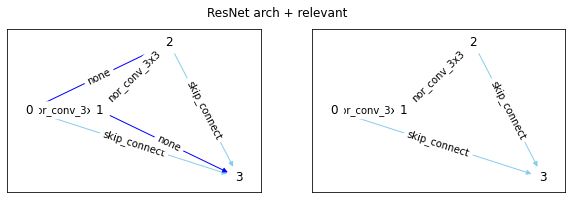

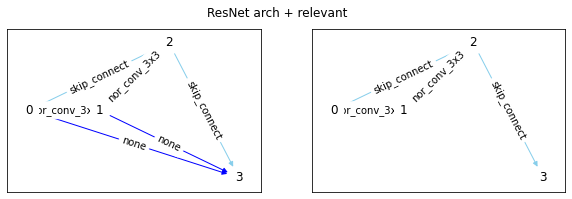

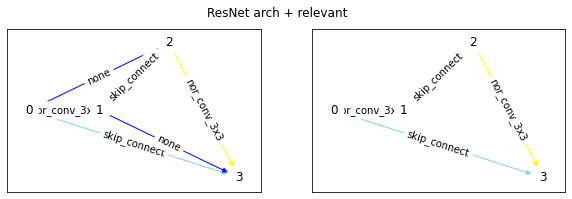

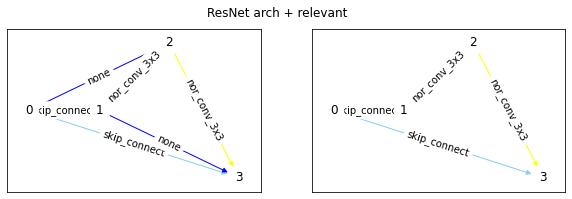

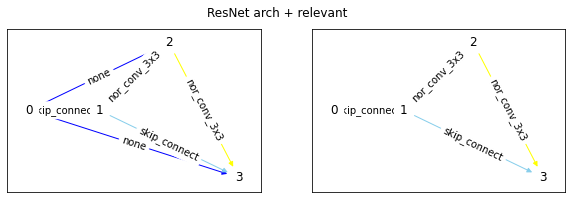

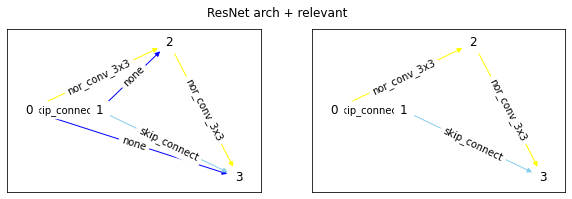

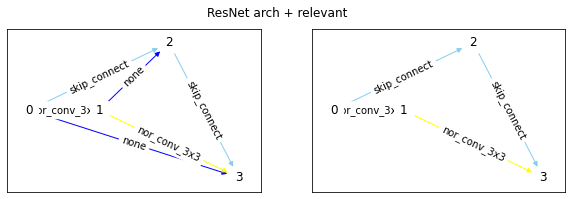

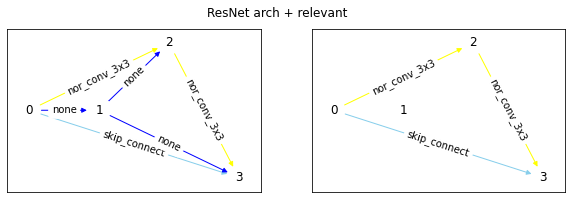

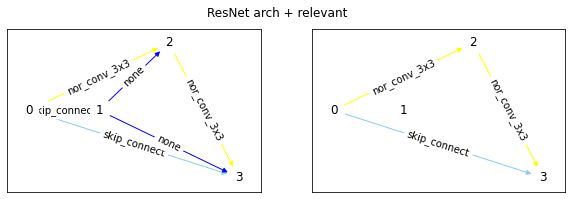

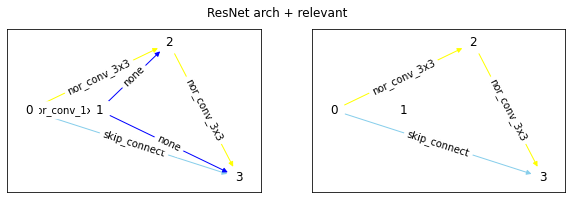

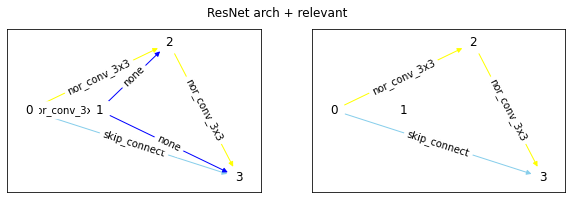

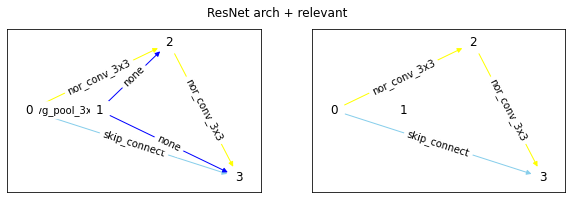

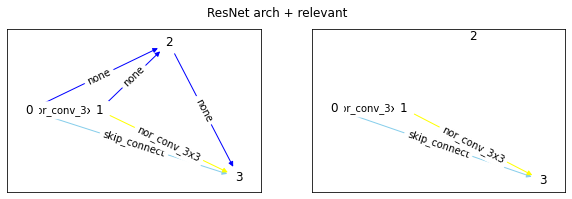

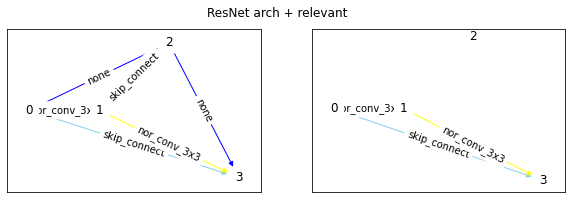

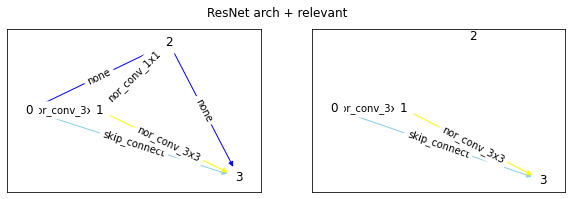

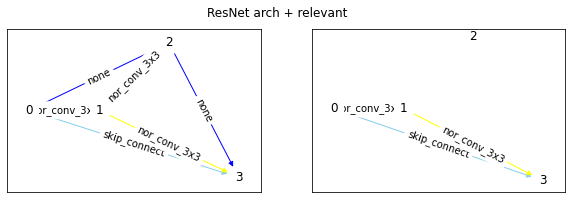

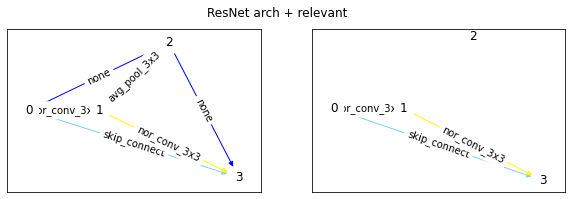

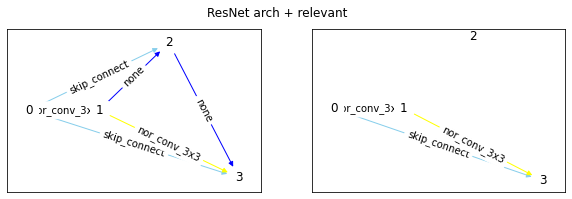

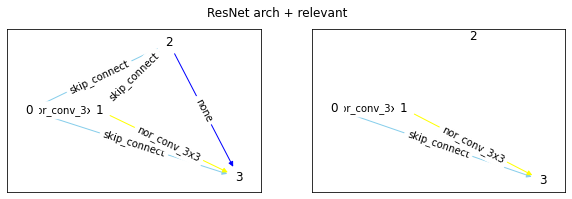

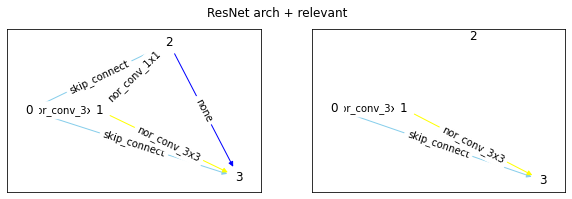

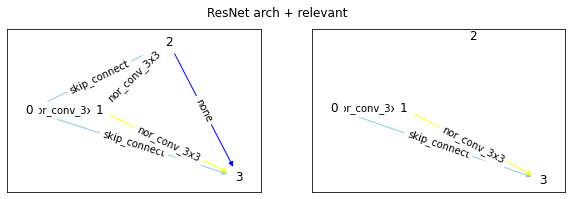

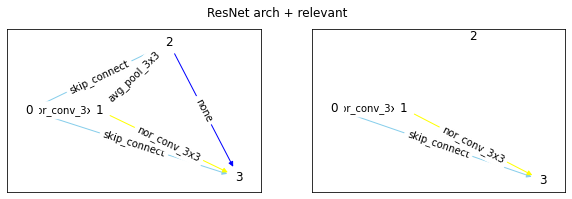

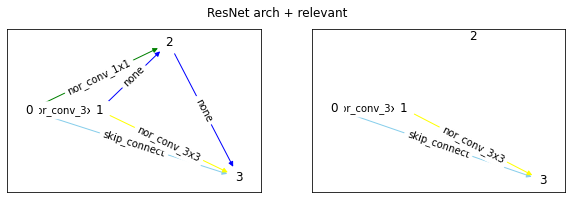

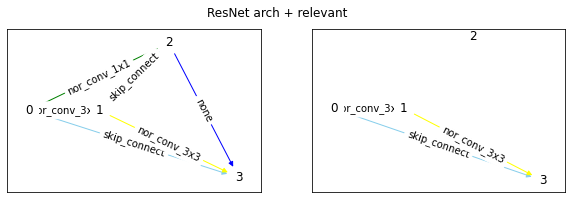

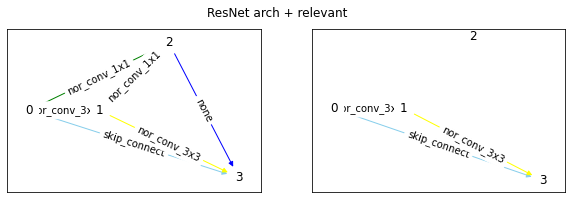

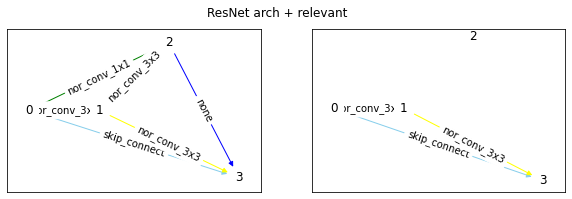

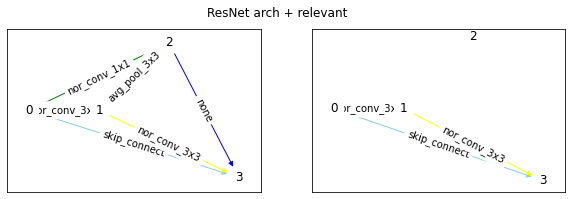

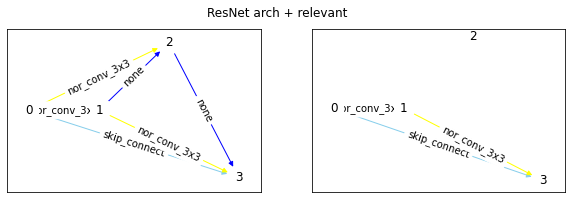

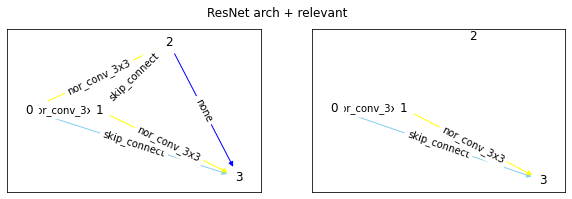

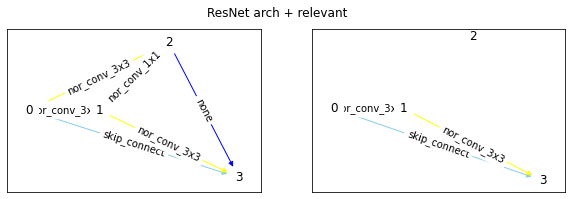

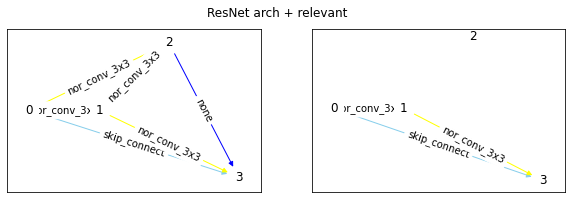

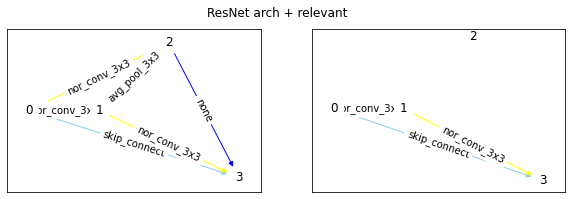

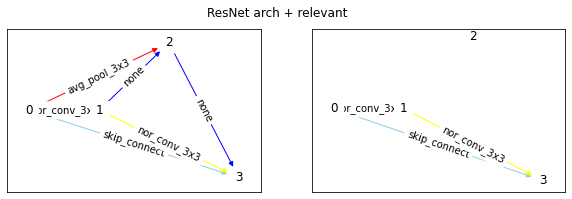

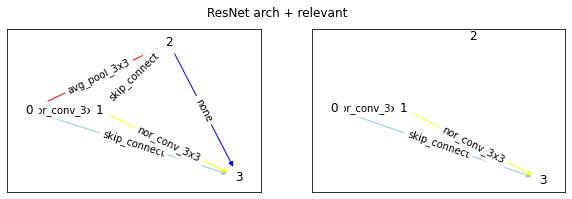

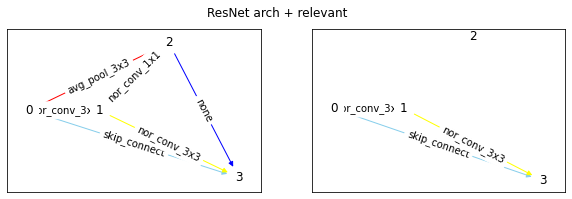

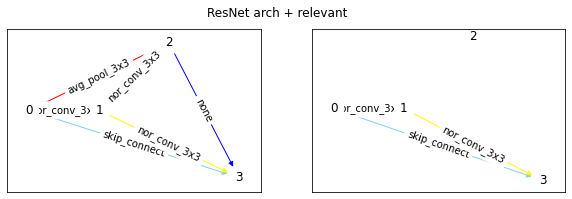

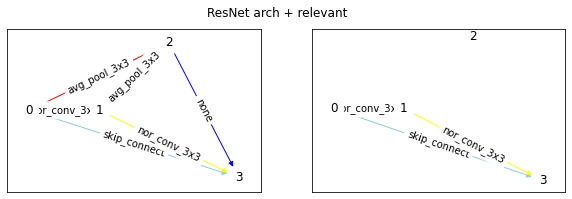

In [5]:
# draw graph all resNet graphs
# import networkx as nx
# import numpy as np
# import matplotlib.pyplot as plt

G = nx.DiGraph()
nodes = np.arange(0, 4).tolist()
G.add_nodes_from(nodes)
G.add_edges_from([(0,1), (0,2), (0,3), (1,2), (1, 3), (2, 3)])
labels = {0:'0', 1:'1', 2:'2', 3:'3'}
pos = {0:(0,0), 1:(2,0), 2:(4,0.5), 3:(6,-0.5)}

operations = ['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']

res_net_archs=[]
# conv: (0,1) (1,2) skip: (0,3)
res_net_archs.append('|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|')
# conv: (0,1) (1,2) skip: (0,2) (2,3)
res_net_archs.append('|nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|none~0|none~1|skip_connect~2|')
# conv: (0,1) (2,3) skip: (0,3)
res_net_archs.append('|nor_conv_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_3x3~2|')
# conv: (1,2) (2,3) skip: (0,3)
res_net_archs.append('|skip_connect~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|none~1|nor_conv_3x3~2|')
# conv: (1,2) (2,3) skip: (0,1) (1,3)
res_net_archs.append('|skip_connect~0|+|none~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|')

# conv: (0,2) (2,3) skip: (0,1) (1,3)
res_net_archs.append('|skip_connect~0|+|nor_conv_3x3~0|none~1|+|none~0|skip_connect~1|nor_conv_3x3~2|')
# conv: (0,1) (1,3) skip: (0,2) (2,3)
res_net_archs.append('|nor_conv_3x3~0|+|skip_connect~0|none~1|+|none~0|nor_conv_3x3~1|skip_connect~2|')


# conv: (0,2) (2,3) skip: (0,3)
# connection (0,1) irrelevant
text = '|*~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|none~1|nor_conv_3x3~2|'
for operation in operations:
    new_arch = text.replace('*', operation)
    res_net_archs.append(new_arch)
# res_net_archs.append('|none~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|none~1|nor_conv_3x3~2|')

# conv: (0,1) (1,3) skip: (0,3)
# connection (0,2) (1,2) irrelevant
# res_net_archs.append('|nor_conv_3x3~0|+|none~0|none~1|+|skip_connect~0|nor_conv_3x3~1|none~2|')
text = '|nor_conv_3x3~0|+|*~0|/~1|+|skip_connect~0|nor_conv_3x3~1|none~2|'

for operation in operations:
    for operation2 in operations:
        temp = text.replace('*', operation)
        new_arch = temp.replace('/', operation2)
        res_net_archs.append(new_arch)

# # visualize all resnet architectures for better understandability
for arch in res_net_archs:
    edge_dict, edge_color = get_edge_labels_and_colors(arch)
    new_G = nx.DiGraph()
    nodes = np.arange(0, 4).tolist()
    new_G.add_nodes_from(nodes)
    relevant_edges = reduce_to_relevant_graph(edge_dict)
    new_G.add_edges_from(relevant_edges.keys())
    new_edge_colors = get_color_array_for_edge_dict(relevant_edges)
    # print(edge_dict)
    # print(edge_color)
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    plt.sca(axs[0])
    nx.draw_networkx(G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color = edge_color)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=edge_dict,font_color='black')
    plt.sca(axs[1])
    nx.draw_networkx(new_G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color=new_edge_colors)
    nx.draw_networkx_edge_labels(new_G, pos = pos, edge_labels=relevant_edges, font_color='black', font_size=10)
    fig.suptitle("ResNet arch + relevant")
    plt.show()

In [6]:
# get all resNet indices
from nats_bench import create
api = create(None, 'tss', fast_mode=True)
# info = api.get_more_info(15234, 'cifar10')
# get resnet index
res_net_ids = []
for arch in res_net_archs:
    res_index = api.query_index_by_arch(arch)
    res_net_ids.append(res_index)

# print(res_net_ids)
# [11472, 2528, 9950, 13755, 6515, 3927, 12295, 69, 9817, 15567, 12645, 14638, 9722, 5731, 9099, 9819, 12451, 4946, 258, 6499, 8401, 8426, 2776, 12956, 8253, 5776, 9997, 295, 15615, 8606, 8413, 5780, 8884, 10750, 11217, 10484, 11174]

[2022-10-16 14:12:17] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.
[2022-10-16 14:12:17] Create NATS-Bench (topology) done with 0/15625 architectures avaliable.
[2022-10-16 14:12:17] Call query_index_by_arch with arch=|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|none~1|skip_connect~2|
[2022-10-16 14:12:17] Call query_index_by_arch with arch=|nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|none~0|none~1|skip_connect~2|
[2022-10-16 14:12:17] Call query_index_by_arch with arch=|nor_conv_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_3x3~2|
[2022-10-16 14:12:17] Call query_index_by_arch with arch=|skip_connect~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|none~1|nor_conv_3x3~2|
[2022-10-16 14:12:17] Call query_index_by_arch with arch=|skip_connect~0|+|none~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|
[2022-10-16 14:12:17] Call query_index_by_arch with arch=|skip_connect~0|+|nor_conv_3x3~0|none~1|+|none~0|skip_con

In [7]:
# find all architectures with only one skip connect path -> resnet-6
def is_only_skip_connect(edge_dict):
    for edge_index in edge_dict:
        edge = edge_dict[edge_index]
        if edge != skip_connection_string:
            return False
    return True


def is_only_one_path(edge_dict):
    is_path = False
    is_first_path = True

    def check_is_first_and_only(is_path):
        is_first_path = not is_path
        is_path = True
        return is_path, is_first_path

    if (0,1) in edge_dict:
        if (1,3) in edge_dict:
            is_path, is_first_path = check_is_first_and_only(is_path)
        if (1,2) in edge_dict and (2,3) in edge_dict:
            is_path, is_first_path = check_is_first_and_only(is_path)
    if (0,2) in edge_dict and (2,3) in edge_dict:
        is_path, is_first_path = check_is_first_and_only(is_path)
    if (0,3) in edge_dict:
        is_path, is_first_path = check_is_first_and_only(is_path)
    return is_path and is_first_path

only_one_skip_ids = []
for index in range(len(all_data)):
    architecture_string = get_architecture_string_by_index(index)
    edge_dict = get_edge_dict(architecture_string)
    relevant_edges = reduce_to_relevant_graph(edge_dict)
    if is_only_skip_connect(relevant_edges) and is_only_one_path(relevant_edges):
        only_one_skip_ids.append(index)

# print(only_one_skip_ids)

In [8]:
# # visualize all graphs with only one skip_connect path
# counter = 0
# for index in only_one_skip_ids: # actually :top_N
#         architecture_string = get_architecture_string_by_index(index)
#         edge_label, edge_colors = get_edge_labels_and_colors(architecture_string)
#         # plt.clf()
#         fig, axs = plt.subplots(1, 2, figsize=(10,3))
#         plt.sca(axs[0])
#         nx.draw_networkx(G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color = edge_colors)
#         nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=edge_label,font_color='black', font_size=10)
#
#         plt.sca(axs[1])
#         new_G = nx.DiGraph()
#         nodes = np.arange(0, 4).tolist()
#         new_G.add_nodes_from(nodes)
#         relevant_edges = reduce_to_relevant_graph(edge_label)
#         new_G.add_edges_from(relevant_edges.keys())
#         new_edge_colors = get_color_array_for_edge_dict(relevant_edges)
#         nx.draw_networkx(new_G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color=new_edge_colors)
#         nx.draw_networkx_edge_labels(new_G, pos = pos, edge_labels=relevant_edges, font_color='black', font_size=10)
#         fig.suptitle(f"Architecture {index}  + only relevant ({counter+1}/{len(only_one_skip_ids)})")
#         counter += 1
#         plt.show()

In [9]:
print(f'resnet_ids = {res_net_ids}')
print(f'skip_arch_ids = {only_one_skip_ids}')
# print(f'number of skip_arch_ids = {len(only_one_skip_ids)}')

resnet_ids = [11472, 2528, 9950, 13755, 6515, 3927, 12295, 69, 9817, 15567, 12645, 14638, 9722, 5731, 9099, 9819, 12451, 4946, 258, 6499, 8401, 8426, 2776, 12956, 8253, 5776, 9997, 295, 15615, 8606, 8413, 5780, 8884, 10750, 11217, 10484, 11174]
skip_arch_ids = [3, 9, 25, 55, 72, 186, 196, 201, 243, 275, 278, 419, 464, 561, 594, 657, 659, 758, 777, 789, 970, 1020, 1051, 1061, 1110, 1140, 1164, 1194, 1263, 1310, 1351, 1384, 1409, 1481, 1497, 1520, 1549, 1565, 1574, 1601, 1610, 1637, 1690, 1755, 1785, 1860, 1863, 1872, 1921, 1962, 1977, 1995, 2090, 2132, 2134, 2152, 2191, 2196, 2211, 2222, 2241, 2265, 2279, 2286, 2304, 2385, 2417, 2481, 2485, 2493, 2518, 2560, 2595, 2707, 2747, 2773, 2803, 2894, 2985, 3022, 3076, 3105, 3157, 3294, 3347, 3374, 3393, 3438, 3442, 3449, 3495, 3501, 3521, 3610, 3665, 3679, 3686, 3691, 3728, 3746, 3793, 3885, 4010, 4028, 4031, 4054, 4100, 4314, 4326, 4384, 4481, 4506, 4512, 4554, 4556, 4559, 4587, 4603, 4607, 4618, 4686, 4739, 4752, 4754, 4988, 4998, 5007, 5019

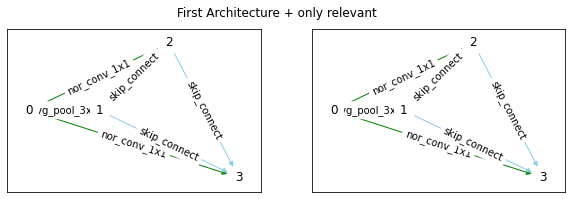

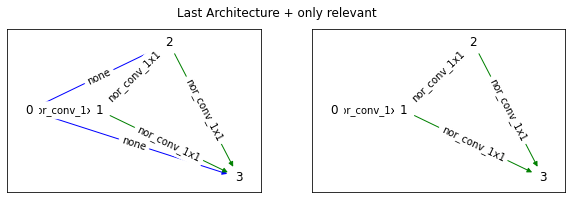

In [10]:
first_arch = get_architecture_string_by_index(0)
last_arch = get_architecture_string_by_index(len(all_data)-1)
counter = 0
for architecture_string in [first_arch, last_arch]:
    edge_label, edge_colors = get_edge_labels_and_colors(architecture_string)
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    plt.sca(axs[0])
    nx.draw_networkx(G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color = edge_colors)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=edge_label,font_color='black', font_size=10)

    plt.sca(axs[1])
    new_G = nx.DiGraph()
    nodes = np.arange(0, 4).tolist()
    new_G.add_nodes_from(nodes)
    relevant_edges = reduce_to_relevant_graph(edge_label)
    new_G.add_edges_from(relevant_edges.keys())
    new_edge_colors = get_color_array_for_edge_dict(relevant_edges)
    nx.draw_networkx(new_G, pos = pos, labels=labels, arrows = True, node_shape = "s", node_color = "white", edge_color=new_edge_colors)
    nx.draw_networkx_edge_labels(new_G, pos = pos, edge_labels=relevant_edges, font_color='black', font_size=10)
    if counter == 0:
        prefix = "First"
    else:
        prefix = "Last"
    counter += 1
    fig.suptitle(f"{prefix} Architecture + only relevant")
    plt.show()
